In [239]:
from openai import OpenAI
import json
import re
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
client = OpenAI()

# Step 1: Explore the data

Explore the data in full

## 1. Metdata csv file

In [3]:
df_call_metadata = pd.read_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/call_metadata.csv')
print(df_call_metadata.head())
print(df_call_metadata.info())

                                    _id     duration            disposition  \
0  1558137f-4ab5-409e-8159-109c2e9358d5  3927.771375    No Pay - Bankruptcy   
1  05c54daf-9bca-4bd7-b833-b3ba8c1e06e0   146.520000  No Pay - Cant pay now   
2  84fb4fec-b36f-43bc-a4ef-a27ba322c146   749.635875       No Pay - Dispute   
3  2133927a-0d11-4d54-98d6-cd21c71417f0   448.104375       No Pay - Dispute   
4  048518c6-c17c-4524-8ff3-6a0b2735863c   108.432000       No Pay - Dispute   

       type  
0  negative  
1  negative  
2  negative  
3  negative  
4  negative  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          2000 non-null   object 
 1   duration     2000 non-null   float64
 2   disposition  2000 non-null   object 
 3   type         2000 non-null   object 
dtypes: float64(1), object(3)
memory usage: 62.6+ KB
None


In [4]:
print(df_call_metadata['type'].value_counts())

type
negative    1000
positive    1000
Name: count, dtype: int64


In [5]:
print(df_call_metadata['disposition'].value_counts())

disposition
No Pay - Dispute                    439
Promise - Payment in full           313
No Pay - Not right now              296
Promise - Payment plan              256
No Pay - Cant pay now               182
Promise - Settlement in full        163
Promise - One time payment          104
Payment Plan Modification           101
Promise - Settlement in payments     63
No Pay - Can't pay now               42
No Pay - Bankruptcy                  30
No Pay - Cancel payment plan         11
Name: count, dtype: int64


In [6]:
disposition_type_counts = df_call_metadata.groupby('disposition')['type'].value_counts().unstack(fill_value=0)
print(disposition_type_counts)

type                              negative  positive
disposition                                         
No Pay - Bankruptcy                     30         0
No Pay - Can't pay now                  42         0
No Pay - Cancel payment plan            11         0
No Pay - Cant pay now                  182         0
No Pay - Dispute                       439         0
No Pay - Not right now                 296         0
Payment Plan Modification                0       101
Promise - One time payment               0       104
Promise - Payment in full                0       313
Promise - Payment plan                   0       256
Promise - Settlement in full             0       163
Promise - Settlement in payments         0        63


In [8]:
positive_dispositions = set(disposition_type_counts[disposition_type_counts['positive'] > 0].index.tolist())
negative_dispositions = set(disposition_type_counts[disposition_type_counts['negative'] > 0].index.tolist())

print("Positive disposition types:", positive_dispositions)
print("Negative disposition types:", negative_dispositions)

Positive disposition types: {'Promise - Settlement in full', 'Promise - One time payment', 'Promise - Payment plan', 'Promise - Settlement in payments', 'Promise - Payment in full', 'Payment Plan Modification'}
Negative disposition types: {'No Pay - Not right now', 'No Pay - Cant pay now', 'No Pay - Bankruptcy', 'No Pay - Dispute', 'No Pay - Cancel payment plan', "No Pay - Can't pay now"}


In [9]:
len(positive_dispositions), len(negative_dispositions)

(6, 6)

### Split dataset into train-val-test

We do 80-10-10 train-val-test split, ensuring there is no class imbalance in either split

In [10]:
from sklearn.model_selection import train_test_split

# Separate positive and negative samples
df_positive = df_call_metadata[df_call_metadata['type'] == 'positive']
df_negative = df_call_metadata[df_call_metadata['type'] == 'negative']

# Calculate split sizes
train_size = 0.8
val_size = 0.1
test_size = 0.1

def split_df(df, train_size, val_size, test_size):
    df_train, df_temp = train_test_split(df, train_size=train_size, random_state=42, shuffle=True)
    relative_val_size = val_size / (val_size + test_size)
    df_val, df_test = train_test_split(df_temp, train_size=relative_val_size, random_state=42, shuffle=True)
    return df_train, df_val, df_test

# Split positive and negative samples
pos_train, pos_val, pos_test = split_df(df_positive, train_size, val_size, test_size)
neg_train, neg_val, neg_test = split_df(df_negative, train_size, val_size, test_size)

# Concatenate to get final splits with equal positive and negative samples
train_df = pd.concat([pos_train, neg_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([pos_val, neg_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([pos_test, neg_test]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Train shape: {train_df.shape}, Positive: {(train_df['type'] == 'positive').sum()}, Negative: {(train_df['type'] == 'negative').sum()}")
print(f"Val shape: {val_df.shape}, Positive: {(val_df['type'] == 'positive').sum()}, Negative: {(val_df['type'] == 'negative').sum()}")
print(f"Test shape: {test_df.shape}, Positive: {(test_df['type'] == 'positive').sum()}, Negative: {(test_df['type'] == 'negative').sum()}")

Train shape: (1600, 4), Positive: 800, Negative: 800
Val shape: (200, 4), Positive: 100, Negative: 100
Test shape: (200, 4), Positive: 100, Negative: 100


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _id          1600 non-null   object 
 1   duration     1600 non-null   float64
 2   disposition  1600 non-null   object 
 3   type         1600 non-null   object 
dtypes: float64(1), object(3)
memory usage: 50.1+ KB


In [12]:
train_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/train_df.csv', index=False)
val_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/val_df.csv', index=False)
test_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/test_df.csv', index=False)

## 2. Conversations

In [13]:
import os

conversation_folder = '/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/conversations'
txt_files = [f for f in os.listdir(conversation_folder) if f.endswith('.txt')]
print(f"Number of text files: {len(txt_files)}")

Number of text files: 2000


In [16]:
# Remove '.txt' extension from txt_files to get basenames
txt_basenames = set([os.path.splitext(f)[0] for f in txt_files])

# Get set of _id values from df_call_metadata
df_ids = set(df_call_metadata['_id'])

assert txt_basenames == df_ids

In [15]:
assert df_call_metadata['_id'].is_unique, "Not all _id values are unique in df_call_metadata"

In [22]:
random_txt = random.choice(txt_files)
txt_path = os.path.join(conversation_folder, random_txt)
with open(txt_path, 'r') as f:
    content = f.read()

display(Markdown(f"### {random_txt}\n\n{content}"))

### 89cd6569-3d4e-4c45-84e8-c6941f8f624d.txt

agent 00:06-00:16
* * * this call is being recorded and may be monitored for quality assurance purposes and by continuing you're providing consent may i please have your first and last name

borrower 00:19-00:20
* *

agent 00:21-00:24
okay thank you and do you happen to have your agency XYZ account number

borrower 00:25-00:26
no i don't

agent 00:27-00:30
okay no worries did you receive an email text or a letter from us

borrower 00:31-00:33
email text one letter sorry

agent 00:34-00:37
okay got it let me see if i can locate your account what is the year of your birthday please the year

borrower 00:39-00:41
* * * * *

agent 00:42-00:48
okay let me see here if you received the letter let me try to search it that way what is your address to where we send that letter to

borrower 00:50-00:56
* * * * * * * * * * * * *

agent 00:57-01:22
okay thank you okay got it i do see an account so very quickly agency XYZ is a debt collection agency this is an attempt to collect debt and any information obtained will be used for that purpose alright so i do see the account with lvnv funding llc originally with via inc and it has a balance of four hundred ninety dollars and nineteen cents did you wanna pay that in full today

borrower 01:24-01:32
i already sent you a check today certified you guys will be signing to get the cashier check it's coming so you should receive it by tomorrow

agent 01:33-02:07
alright i'll go ahead and make the note on the account and as soon as we receive it we'll send you an email confirmation of the account being closed okay perfect alrighty now a couple of things just to make sure we send it to the correct email we have * your last name * * * is that a good email twelve phone mills perfect so we'll send conns confirmation there and the phone number we have on file is it * * * * * * * * * * is that also accurate

borrower 01:56-01:57
yep yep

borrower 02:07-02:09
yep yep

agent 02:09-02:12
perfect alrighty for now was there anything else i can assist you with

borrower 02:14-02:14
nope

agent 02:15-02:19
perfect alright well i do thank you for calling agency XYZ and i hope you have a great rest of your day

### Format every content better

I want to create a format of the convo as `{"borrower": <text>, "agent": <text>, ...}` and save them in json files

In [27]:
def format_conv_from_content(content):
    lines = content.splitlines()
    lines_fil = [line.strip() for line in lines if len(line.strip()) > 0]
    convo = []
    speaker = None
    text = []
    speaker_re = re.compile(r'^(agent|borrower)\s+\d{2}:\d{2}-\d{2}:\d{2}$', re.IGNORECASE)
    for line in lines_fil:
        if speaker_re.match(line):
            if speaker and text:
                convo.append({"speaker": speaker, "text": " ".join(text)})
            speaker = line.split()[0].lower()
            text = []
        else:
            text.append(line)
    if speaker and text:
        convo.append({"speaker": speaker, "text": " ".join(text)})
    return convo


In [29]:
for txt_file in txt_files:
    txt_path = os.path.join(conversation_folder, txt_file)
    with open(txt_path, 'r') as f:
        content = f.read()
    formatted = format_conv_from_content(content)
    json_path = os.path.splitext(txt_path)[0] + '.json'
    with open(json_path, 'w') as jf:
        json.dump(formatted, jf, indent=2)

# Step 2: Identify Potential PII

For each conversation, flag potential PII in the call logs. Mostly looked clean, but imp to do a sanity check on a sample

In [61]:
pii_filter_prompt = """
# Context:
"You are an AI assistant tasked with identifying and flagging customer Personally Identifiable Information (PII) within a given text. Your role is to act as a data protection filter.

You will be given a conversation between an AI agent and a customer as input. Here is how you should operate:
1.  Analyze the following conversation content provided between an AI agent and a customer.
2.  Your primary objective is to determine if any customer PII is present in the text. PII includes, but is not limited to:
    *   Names (full names, first names, last names)
    *   Email addresses
    *   Phone numbers
    *   Physical addresses (street, city, state, zip code)
    *   Social Security numbers or other government-issued identification numbers
    *   Credit card numbers or financial account information
    *   Dates of birth
    *   Login credentials (usernames, passwords)
    *   Medical information
    *   IP addresses or other unique device identifiers
3. Crucially, you must **ignore any data that has been masked**. Masked data is information that has been partially or fully obscured. Common examples of masking techniques to ignore include:
    - Redaction/Masking Out: Replacing parts of the data with characters like 'X', '*', or '#'. For instance, XXX-XX-1234 or john.doe@******.com.
    - Substitution/Replacement: Replacing sensitive data with fictitious yet realistic-looking data. For example, a real name might be replaced with a randomly generated one.
    - Tokenization/Encryption: Replacing data with a non-sensitive placeholder or an encrypted string.
    - Nulling Out: Replacing sensitive information with null values or blanks.
4. **Ignore Agent Names**: You must differentiate between the agent and the customer and ignore the agent's name. The agent's name may be stated explicitly (e.g., "My name is Alex," "This is SupportBot," or "You're speaking with Sarah."). Your focus is exclusively on identifying the **customer's PII**.
5.  After your analysis, you will provide a binary output:
    *   Return **1** if you identify any potential PII in the conversation that is unmasked.
    *   Return **0** if you do not find any PII in the conversation or **all** potential PII is masked out

# Output Format:
- Analysis of the conversation: <Detailed analysis of the conversation between the AI agent and customer wrt finding potential PII>
- Identified PII: <List of potential customer PII data identified in the conversation. Return None if the input is customer PII free>
- Score: <0 if there is no customer PII in the conversation or all customer PII is masked, 1 otherwise>

IMPORTANT: Remember to always adhere to this output format for consistency

# Input
Input Content: {conv} 

# Output
"""

In [63]:
p = deepcopy(pii_filter_prompt)
random_txt = random.choice(txt_files)
txt_path = os.path.join(conversation_folder, random_txt)
txt_path = '/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/conversations/f8832c53-8b6c-4f73-bcce-b06c4f89b0f3.txt'
with open(txt_path, 'r') as f:
    content = f.read()

p = p.format(conv=content)
response = client.responses.create(
    model="gpt-4.1",
    input=p
)

display(Markdown(response.output_text))


- Analysis of the conversation:  
Upon reviewing the conversation, I analyzed all exchanges between the agent and the borrower (customer). All possible PII fields such as names ("miss *", etc.), email addresses, and other sensitive data were indicated with masking ("*," "* *," etc.) and are therefore not to be considered as actual unmasked PII under the provided guidelines. Additionally, a statement regarding the customer's health status ("i'm going through cancer right now i i'm i'm in radiation") is mentioned, which is medical information and constitutes PII; however, it is not masked and thus counts as unmasked PII. No unmasked names, contact details, or financial/account information are present—the rest is either masked or relates to public company/agent information.

- Identified PII: 
    - Medical information: The customer discloses undergoing cancer treatment and radiation ("i'm going through cancer right now i i'm i'm in radiation i just got a radiation").

- Score: 1

In [65]:
def extract_sections(text):
    analysis = None
    pii = None
    score = None

    analysis_match = re.search(r'- Analysis of the conversation:\s*(.*?)(?:- Identified PII:|$)', text, re.DOTALL)
    pii_match = re.search(r'- Identified PII:\s*(.*?)(?:- Score:|$)', text, re.DOTALL)
    score_match = re.search(r'- Score:\s*(\d+)', text)

    if analysis_match:
        analysis = analysis_match.group(1).strip()
    if pii_match:
        pii = pii_match.group(1).strip()
    if score_match:
        score = int(score_match.group(1).strip())

    return analysis, pii, score

def get_pii_score(prompt, file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    try:
        p = deepcopy(prompt)
        p = p.format(conv=content)
        response = client.responses.create(
            model="gpt-4.1",
            input=p
        )
        response_out = response.output_text
        analysis, pii, score = extract_sections(response_out)
        result = {
            "file": file_path,
            "analysis": analysis,
            "pii": pii,
            "score": score
        }
        return result
    except Exception as e:
        print(e)
        return None

In [66]:
txt_paths = [os.path.join(conversation_folder, fname) for fname in txt_files]
len(txt_paths)

2000

In [67]:
results = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(get_pii_score, pii_filter_prompt, file_path) for file_path in txt_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results.append(future.result())

Processing Files: 100%|██████████| 2000/2000 [09:12<00:00,  3.62it/s]


In [68]:
results_fil = [res for res in results if res is not None]
results_df = pd.DataFrame(results_fil)

In [69]:
print(results_df['score'].value_counts())

score
0    1894
1     106
Name: count, dtype: int64


In [85]:
i = random.randint(0, len(results_df[results_df['score'] == 1]))
i

56

In [86]:
display(Markdown(results_df[results_df['score'] == 1].iloc[i]["pii"]))

1. Customer first name: "natalie"
2. Unmasked customer account number: "four seven dash zero zero dash two seven one nine dash three one nine two zero" (47-00-2719-31920)

## Conclusion:
- Most of the PII is masked in this conversation
- Some PII is missed is mostly single names, diseases or when emails/phone no.s are spelled out. eg: "our seven dash zero zero dash two seven one nine dash three one nine two zero" spelled out
- Rule based PII failed but stronger LLM based filtering was able to catch it.

# 3. Get Zero Shot Prompting Results

Lets prompt some basic OpenAI LLMs and get the scores of agent and borrower sentiment

## Metrics:
- Text files Zero Shot: 
    - Optimal threshold: 0.64
    - Accuracy: 0.7526
    - Precision: 0.7316
    - Recall: 0.7984
    - F1 Score: 0.7635
- Json files Zero Shot:
    - Optimal threshold: 0.61
    - Accuracy: 0.7481
    - Precision: 0.7143
    - Recall: 0.8258
    - F1 Score: 0.7660

In [163]:
sentiment_zero_shot_prompt = """
# INSTRUCTIONS:

You are an expert in sentiment analysis. Your task is to analyze the following conversation between an "Agent" (AI) and a "Borrower" (human). After your analysis, you will provide two overall sentiment scores: one for the Agent and one for the Borrower. 

The sentiment scores should be on a scale from 0 to 1, where **0 represents the most negative sentiment** and **1 represents the most positive sentiment**. 

**Follow these steps for your analysis:** 

1.  **Read the entire conversation carefully** to understand the context and the emotional tone of both the Agent and the Borrower. 
2.  **Identify key phrases and sentences** that indicate the sentiment of each participant. Consider the choice of words, the tone, and any emotional cues. 
3.  **Analyze the sentiment of the Agent** throughout the conversation. Note any shifts in tone, from professional and helpful to apologetic or firm. 
4.  **Analyze the sentiment of the Borrower** throughout the conversation. Note any expressions of frustration, satisfaction, confusion, or gratitude. 
5.  **Determine an overall sentiment score for the Agent** based on your analysis. This score should reflect the Agent's dominant sentiment throughout the entire interaction. 
6.  **Determine an overall sentiment score for the Borrower** based on your analysis. This score should reflect the Borrower's dominant sentiment throughout the entire interaction. 
7.  **Provide a brief justification** for each score, referencing specific parts of the conversation.  

# Output Format:
Provide your analysis in the following JSON format. Do not include any text or explanations outside of the JSON structure.
```
{ 
  "conversation_analysis": { 
    "agent_sentiment": { 
      "analysis": <detailed analysis of the agent sentiment based on the input conversation to help determine a sentiment score>
      "score": <a score between 0-1 indicating the agent sentiment, 0 being the most negative and 1 being the most positive>, 
    }, 
    "borrower_sentiment": { 
      "analysis": <detailed analysis of the borrower sentiment based on the input conversation to help determine a sentiment score>
      "score": <a score between 0-1 indicating the borrower sentiment, 0 being the most negative and 1 being the most positive>,
    } 
  } 
} 
```

**IMPORTANT**: Follow this output format strictly without extra formatting to ensure consistency

# Input:
Conversation: @conv@
"""

In [224]:
def get_sentiment_scores(prompt, file_path):
    try:
        id = os.path.basename(file_path).split(".")[0]
        ext = os.path.basename(file_path).split(".")[-1]

        if ext == "txt":
            with open(file_path, "r") as f:
                content = f.read()
        elif ext =="json":
            with open(file_path, 'r') as f:
                content = json.load(f)
                content = str(content)
            
        p = deepcopy(prompt)
        p = p.replace("@conv@", content)
        response = client.responses.create(
            model="gpt-4.1",
            input=p
        )
        response_out = response.output_text

        # display(Markdown(response_out))

        result = json.loads(response_out.strip("```").strip("json"))

        return_val = {
            "_id": id,
            "agent_analysis": result["conversation_analysis"]["agent_sentiment"]["analysis"],
            "agent_score": float(result["conversation_analysis"]["agent_sentiment"]["score"]),
            "borrower_analysis": result["conversation_analysis"]["borrower_sentiment"]["analysis"],
            "borrower_score": float(result["conversation_analysis"]["borrower_sentiment"]["score"]),
        }
        return return_val
    
    except Exception as e:
        print(e)
        return None

## Taking raw txt files

In [206]:
results_txt = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(get_sentiment_scores, sentiment_zero_shot_prompt, file_path) for file_path in txt_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results_txt.append(future.result())

Processing Files:   4%|▍         | 78/2000 [00:43<12:22,  2.59it/s] 

Expecting ',' delimiter: line 6 column 7 (char 788)


Processing Files:  25%|██▌       | 506/2000 [04:30<08:11,  3.04it/s]

Extra data: line 14 column 1 (char 1798)


Processing Files:  52%|█████▏    | 1032/2000 [09:03<06:07,  2.64it/s]

Invalid control character at: line 9 column 936 (char 1780)


Processing Files:  65%|██████▌   | 1305/2000 [11:29<05:19,  2.18it/s]

Expecting ',' delimiter: line 4 column 202 (char 257)


Processing Files:  84%|████████▍ | 1678/2000 [14:40<02:55,  1.84it/s]

Expecting ',' delimiter: line 5 column 374 (char 433)


Processing Files:  86%|████████▋ | 1726/2000 [15:03<01:42,  2.67it/s]

Expecting value: line 1 column 1 (char 0)


Processing Files:  91%|█████████▏| 1825/2000 [15:55<01:19,  2.19it/s]

Expecting ',' delimiter: line 5 column 191 (char 250)


Processing Files: 100%|██████████| 2000/2000 [17:35<00:00,  1.89it/s]


In [207]:
results_txt_fil = [res for res in results_txt if res is not None]
results_txt_df = pd.DataFrame(results_txt_fil)
results_txt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1993 entries, 0 to 1992
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                1993 non-null   object 
 1   agent_analysis     1993 non-null   object 
 2   agent_score        1993 non-null   float64
 3   borrower_analysis  1993 non-null   object 
 4   borrower_score     1993 non-null   float64
dtypes: float64(2), object(3)
memory usage: 78.0+ KB


In [219]:
results_txt_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/gpt_41_txt_file_zero_shot.csv', index=False)

In [208]:
merged_df = df_call_metadata.merge(results_txt_df, on="_id", how="inner")
merged_df.head()

,_id,duration,disposition,type,agent_analysis,agent_score,borrower_analysis,borrower_score
0,1558137f-4ab5-409e-8159-109c2e9358d5,3927.771375,No Pay - Bankruptcy,negative,"The Agent maintains a professional, helpful, a...",0.97,The Borrower initially expresses a neutral and...,0.85
1,05c54daf-9bca-4bd7-b833-b3ba8c1e06e0,146.520000,No Pay - Cant pay now,negative,The Agent maintains a consistently professiona...,0.92,The Borrower’s responses are brief and mostly ...,0.42
2,84fb4fec-b36f-43bc-a4ef-a27ba322c146,749.635875,No Pay - Dispute,negative,The agent maintains a professional and helpful...,0.92,"The borrower expresses confusion, frustration,...",0.32
3,2133927a-0d11-4d54-98d6-cd21c71417f0,448.104375,No Pay - Dispute,negative,The Agent maintains a consistently professiona...,0.95,The Borrower starts off neutral but quickly ex...,0.55
4,048518c6-c17c-4524-8ff3-6a0b2735863c,108.432000,No Pay - Dispute,negative,The Agent (Laura Loretta) maintains a consiste...,0.75,"The Borrower displays confusion, mild frustrat...",0.30


In [209]:
merged_df['ground_truth_sentiment'] = (merged_df['type'] == 'positive').astype(int)

In [210]:
# Calculate correlation coefficients between ground_truth_sentiment and agent_score, borrower_score
corr_agent = merged_df['ground_truth_sentiment'].corr(merged_df['agent_score'])
corr_borrower = merged_df['ground_truth_sentiment'].corr(merged_df['borrower_score'])

print(f"Correlation (ground_truth_sentiment, agent_score): {corr_agent:.4f}")
print(f"Correlation (ground_truth_sentiment, borrower_score): {corr_borrower:.4f}")

Correlation (ground_truth_sentiment, agent_score): 0.3390
Correlation (ground_truth_sentiment, borrower_score): 0.5352


         agent_score                                                    \
               count      mean       std   min   25%   50%   75%   max   
type                                                                     
negative       996.0  0.890171  0.088632  0.50  0.85  0.92  0.95  0.98   
positive       997.0  0.940762  0.044881  0.65  0.93  0.95  0.97  1.00   

         borrower_score                                                   
                  count      mean       std   min   25%  50%   75%   max  
type                                                                      
negative          996.0  0.509970  0.170384  0.10  0.38  0.5  0.65  0.95  
positive          997.0  0.699308  0.125156  0.28  0.65  0.7  0.78  0.95  


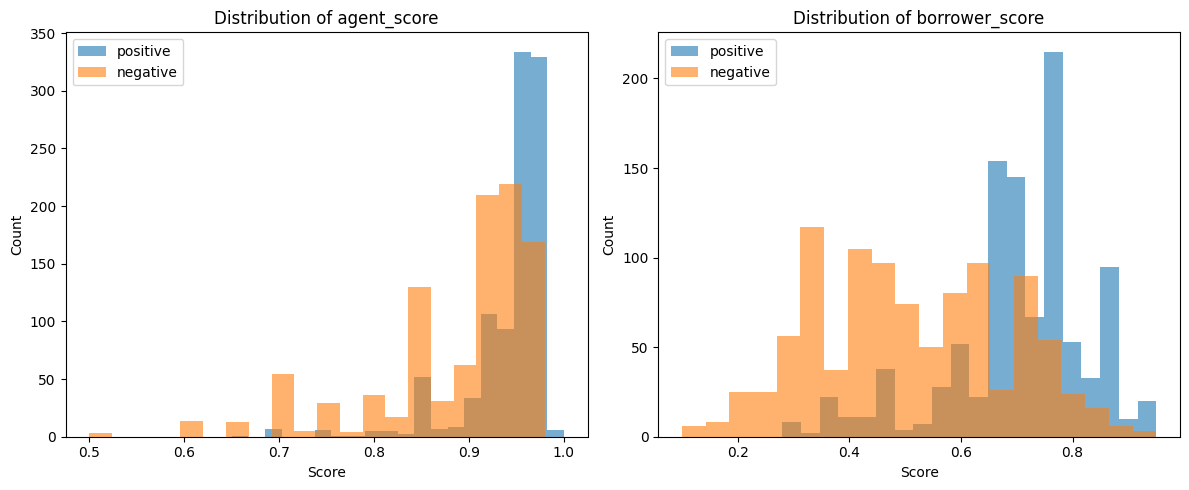

<Figure size 1000x500 with 0 Axes>

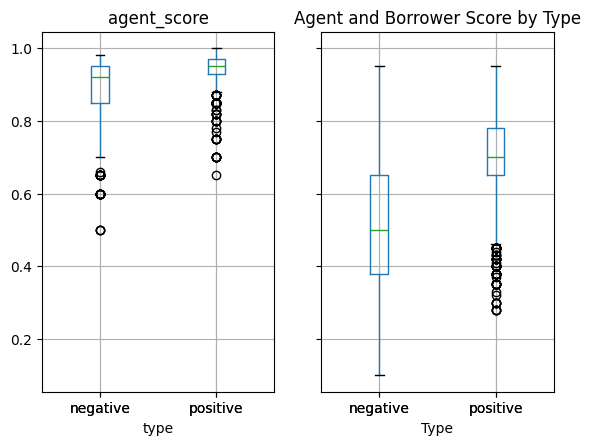

In [211]:
# Group by 'type' and describe agent_score and borrower_score
stats = merged_df.groupby('type')[['agent_score', 'borrower_score']].describe()
print(stats)

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, score_type in enumerate(['agent_score', 'borrower_score']):
    for sentiment_type in ['positive', 'negative']:
        subset = merged_df[merged_df['type'] == sentiment_type][score_type]
        axes[i].hist(subset, bins=20, alpha=0.6, label=sentiment_type)
    axes[i].set_title(f'Distribution of {score_type}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Boxplots for visual comparison
plt.figure(figsize=(10, 5))
merged_df.boxplot(column=['agent_score', 'borrower_score'], by='type')
plt.suptitle('')
plt.title('Agent and Borrower Score by Type')
plt.xlabel('Type')
plt.ylabel('Score')
plt.show()


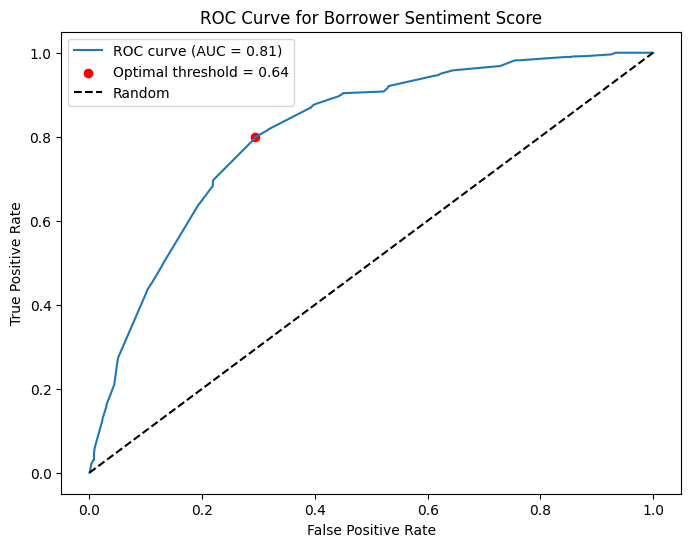

Optimal threshold: 0.64
ROC-AUC: 0.81


In [213]:
from sklearn.metrics import roc_curve, roc_auc_score

# Prepare true labels and predicted scores from merged_df
y_true = merged_df['ground_truth_sentiment']
y_scores = merged_df['borrower_score']

# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Find optimal threshold (maximizing TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Borrower Sentiment Score')
plt.legend()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Optimal threshold: 0.64
Accuracy: 0.7526
Precision: 0.7316
Recall: 0.7984
F1 Score: 0.7635
Confusion Matrix:


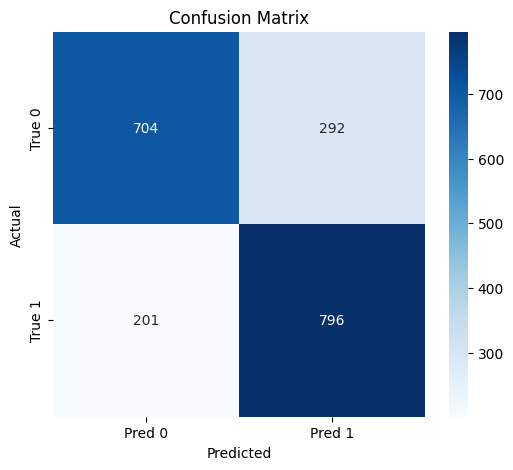

In [218]:
from sklearn.metrics import confusion_matrix

# Use optimal_threshold from previous ROC analysis
pred_optimal = (merged_df['borrower_score'] >= optimal_threshold).astype(int)
true_labels = merged_df['ground_truth_sentiment']

acc = accuracy_score(true_labels, pred_optimal)
prec = precision_score(true_labels, pred_optimal, zero_division=0)
rec = recall_score(true_labels, pred_optimal, zero_division=0)
f1 = f1_score(true_labels, pred_optimal, zero_division=0)
cm = confusion_matrix(true_labels, pred_optimal)

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Taking json files

In [227]:
json_paths = [path.replace('.txt', '.json') for path in txt_paths]

In [228]:
results_json = []

with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(get_sentiment_scores, sentiment_zero_shot_prompt, file_path) for file_path in json_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Files"):
        results_json.append(future.result())

Processing Files:   0%|          | 7/2000 [00:08<18:50,  1.76it/s]  

Invalid control character at: line 9 column 821 (char 2102)


Processing Files:  11%|█▏        | 228/2000 [01:50<16:55,  1.75it/s]

Invalid control character at: line 5 column 736 (char 795)


Processing Files:  22%|██▏       | 433/2000 [03:31<12:10,  2.14it/s]

Invalid control character at: line 5 column 834 (char 893)


Processing Files:  36%|███▌      | 723/2000 [05:46<06:25,  3.31it/s]

Expecting ',' delimiter: line 6 column 7 (char 882)


Processing Files:  41%|████      | 820/2000 [06:32<13:07,  1.50it/s]

Extra data: line 14 column 1 (char 1951)


Processing Files:  46%|████▌     | 913/2000 [07:13<06:20,  2.86it/s]

Invalid \escape: line 5 column 257 (char 316)


Processing Files:  52%|█████▏    | 1031/2000 [08:09<06:14,  2.59it/s]

Expecting ',' delimiter: line 6 column 7 (char 872)


Processing Files:  70%|███████   | 1406/2000 [11:22<04:09,  2.38it/s]

Expecting ',' delimiter: line 9 column 191 (char 1214)


Processing Files:  89%|████████▉ | 1788/2000 [14:28<02:05,  1.68it/s]

Invalid control character at: line 9 column 548 (char 1305)


Processing Files:  96%|█████████▋| 1925/2000 [15:42<00:47,  1.57it/s]

Invalid control character at: line 9 column 774 (char 1843)


Processing Files:  99%|█████████▉| 1979/2000 [16:11<00:11,  1.81it/s]

Expecting ',' delimiter: line 8 column 583 (char 1658)


Processing Files: 100%|██████████| 2000/2000 [16:29<00:00,  2.02it/s]


In [230]:
results_json_fil = [res for res in results_json if res is not None]
results_json_df = pd.DataFrame(results_json_fil)
results_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                1989 non-null   object 
 1   agent_analysis     1989 non-null   object 
 2   agent_score        1989 non-null   float64
 3   borrower_analysis  1989 non-null   object 
 4   borrower_score     1989 non-null   float64
dtypes: float64(2), object(3)
memory usage: 77.8+ KB


In [231]:
results_json_df.to_csv('/Users/sohammistri/Documents/Prodigal-Take-Home/sentiment-take-home/gpt_41_json_file_zero_shot.csv', index=False)

In [232]:
merged_df = df_call_metadata.merge(results_json_df, on="_id", how="inner")
merged_df.head()

,_id,duration,disposition,type,agent_analysis,agent_score,borrower_analysis,borrower_score
0,1558137f-4ab5-409e-8159-109c2e9358d5,3927.771375,No Pay - Bankruptcy,negative,The agent maintains a consistently professiona...,0.97,The borrower expresses mild frustration and co...,0.78
1,05c54daf-9bca-4bd7-b833-b3ba8c1e06e0,146.520000,No Pay - Cant pay now,negative,"The Agent remains professional, courteous, and...",0.92,"The Borrower begins with brief, neutral respon...",0.57
2,84fb4fec-b36f-43bc-a4ef-a27ba322c146,749.635875,No Pay - Dispute,negative,The Agent maintains a professional and courteo...,0.93,The Borrower starts the conversation neutrally...,0.45
3,2133927a-0d11-4d54-98d6-cd21c71417f0,448.104375,No Pay - Dispute,negative,The agent maintains a professional and helpful...,0.93,"The borrower starts from a neutral position, p...",0.45
4,048518c6-c17c-4524-8ff3-6a0b2735863c,108.432000,No Pay - Dispute,negative,The agent consistently maintains a neutral to ...,0.85,The borrower's sentiment starts neutral with a...,0.35


In [233]:
merged_df['ground_truth_sentiment'] = (merged_df['type'] == 'positive').astype(int)

In [234]:
# Calculate correlation coefficients between ground_truth_sentiment and agent_score, borrower_score
corr_agent = merged_df['ground_truth_sentiment'].corr(merged_df['agent_score'])
corr_borrower = merged_df['ground_truth_sentiment'].corr(merged_df['borrower_score'])

print(f"Correlation (ground_truth_sentiment, agent_score): {corr_agent:.4f}")
print(f"Correlation (ground_truth_sentiment, borrower_score): {corr_borrower:.4f}")

Correlation (ground_truth_sentiment, agent_score): 0.3519
Correlation (ground_truth_sentiment, borrower_score): 0.5255


         agent_score                                                  \
               count      mean       std  min   25%   50%   75%  max   
type                                                                   
negative       996.0  0.870100  0.099757  0.5  0.85  0.92  0.95  1.0   
positive       993.0  0.929426  0.050012  0.6  0.92  0.95  0.96  1.0   

         borrower_score                                                   
                  count      mean       std   min   25%  50%   75%   max  
type                                                                      
negative          996.0  0.518102  0.166287  0.10  0.40  0.5  0.65  0.93  
positive          993.0  0.698510  0.122624  0.23  0.65  0.7  0.78  0.98  


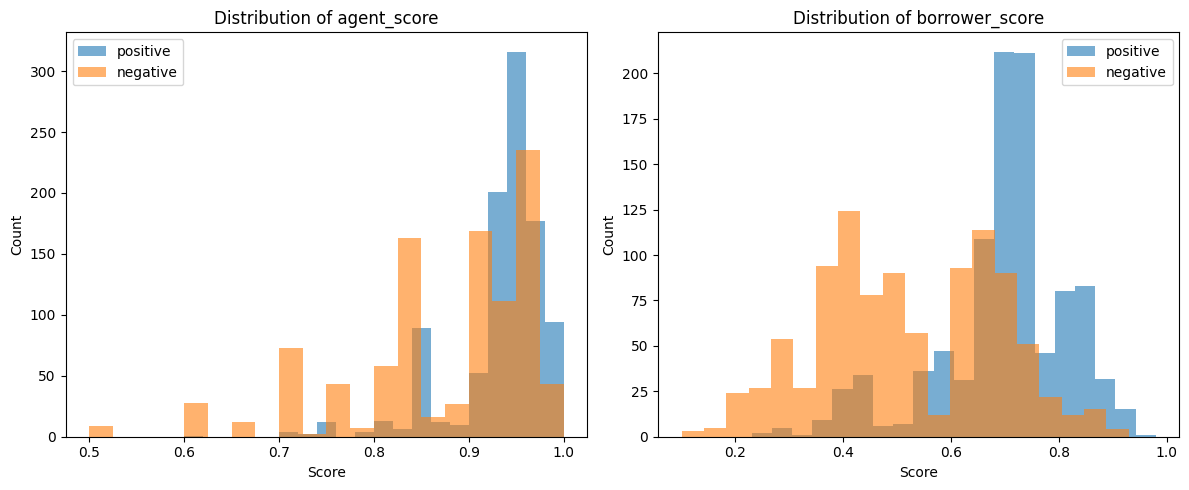

<Figure size 1000x500 with 0 Axes>

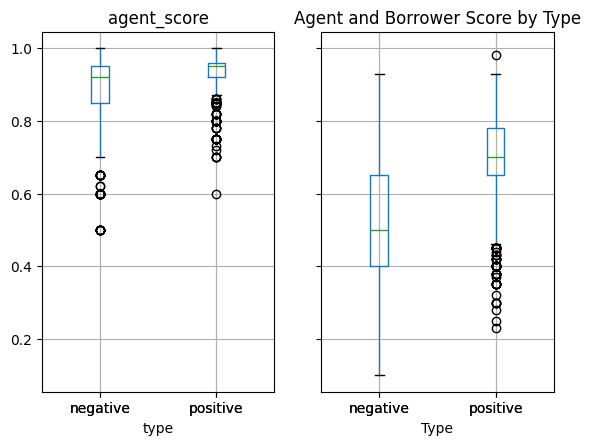

In [235]:
# Group by 'type' and describe agent_score and borrower_score
stats = merged_df.groupby('type')[['agent_score', 'borrower_score']].describe()
print(stats)

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, score_type in enumerate(['agent_score', 'borrower_score']):
    for sentiment_type in ['positive', 'negative']:
        subset = merged_df[merged_df['type'] == sentiment_type][score_type]
        axes[i].hist(subset, bins=20, alpha=0.6, label=sentiment_type)
    axes[i].set_title(f'Distribution of {score_type}')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Boxplots for visual comparison
plt.figure(figsize=(10, 5))
merged_df.boxplot(column=['agent_score', 'borrower_score'], by='type')
plt.suptitle('')
plt.title('Agent and Borrower Score by Type')
plt.xlabel('Type')
plt.ylabel('Score')
plt.show()


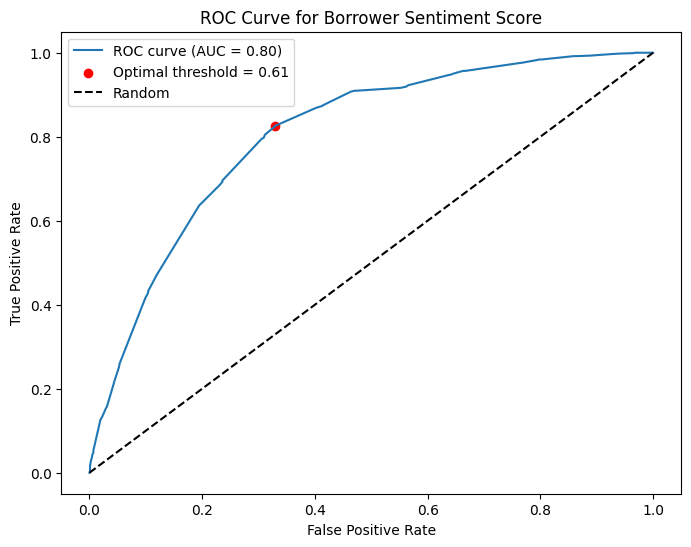

Optimal threshold: 0.61
ROC-AUC: 0.80


In [236]:
from sklearn.metrics import roc_curve, roc_auc_score

# Prepare true labels and predicted scores from merged_df
y_true = merged_df['ground_truth_sentiment']
y_scores = merged_df['borrower_score']

# Compute ROC curve and ROC-AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

# Find optimal threshold (maximizing TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Borrower Sentiment Score')
plt.legend()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Optimal threshold: 0.61
Accuracy: 0.7481
Precision: 0.7143
Recall: 0.8258
F1 Score: 0.7660
Confusion Matrix:


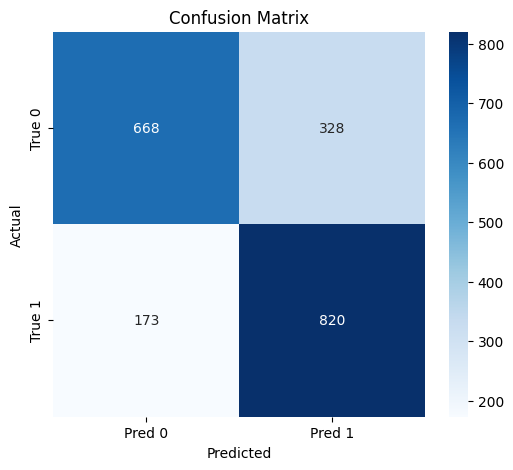

In [237]:
from sklearn.metrics import confusion_matrix

# Use optimal_threshold from previous ROC analysis
pred_optimal = (merged_df['borrower_score'] >= optimal_threshold).astype(int)
true_labels = merged_df['ground_truth_sentiment']

acc = accuracy_score(true_labels, pred_optimal)
prec = precision_score(true_labels, pred_optimal, zero_division=0)
rec = recall_score(true_labels, pred_optimal, zero_division=0)
f1 = f1_score(true_labels, pred_optimal, zero_division=0)
cm = confusion_matrix(true_labels, pred_optimal)

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
train_df = pd.read_csv('/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/train_df.csv')

# Replace the specified value in the 'disposition' column
train_df['disposition'] = train_df['disposition'].replace("No Pay - Can't pay now", "No Pay - Cant pay now")

# Display the updated DataFrame
display(train_df['disposition'].value_counts())
print("Sum of value_counts:", train_df['disposition'].value_counts().sum())
print("Length of train_df:", len(train_df))
# train_df.to_csv("/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/val_df.csv")

disposition
No Pay - Dispute                    348
Promise - Payment in full           247
No Pay - Not right now              239
Promise - Payment plan              211
No Pay - Cant pay now               179
Promise - Settlement in full        139
Promise - One time payment           80
Payment Plan Modification            77
Promise - Settlement in payments     46
No Pay - Bankruptcy                  24
No Pay - Cancel payment plan         10
Name: count, dtype: int64

Sum of value_counts: 1600
Length of train_df: 1600


In [23]:
# Create id2label and label2id mappings for all unique dispositions in train_df
unique_dispositions = train_df['disposition'].unique()
id2label_agent = {i: disp for i, disp in enumerate(unique_dispositions)}
label2id_agent = {disp: i for i, disp in id2label_disposition.items()}

print("id2label_disposition:", id2label_agent)
print("label2id_disposition:", label2id_agent)

id2label_disposition: {0: 'Promise - Payment plan', 1: 'Promise - Settlement in full', 2: 'No Pay - Cant pay now', 3: 'No Pay - Not right now', 4: 'No Pay - Dispute', 5: 'Promise - Payment in full', 6: 'No Pay - Bankruptcy', 7: 'Promise - One time payment', 8: 'Promise - Settlement in payments', 9: 'Payment Plan Modification', 10: 'No Pay - Cancel payment plan'}
label2id_disposition: {'Promise - Payment plan': 0, 'Promise - Settlement in full': 1, 'No Pay - Cant pay now': 2, 'No Pay - Not right now': 3, 'No Pay - Dispute': 4, 'Promise - Payment in full': 5, 'No Pay - Bankruptcy': 6, 'Promise - One time payment': 7, 'Promise - Settlement in payments': 8, 'Payment Plan Modification': 9, 'No Pay - Cancel payment plan': 10}


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1600 non-null   int64  
 1   _id          1600 non-null   object 
 2   duration     1600 non-null   float64
 3   disposition  1600 non-null   object 
 4   type         1600 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 62.6+ KB


In [28]:

id2label_agent = {0: 'Promise - Payment plan', 1: 'Promise - Settlement in full',\
                   2: 'No Pay - Cant pay now', 3: 'No Pay - Not right now',\
                      4: 'No Pay - Dispute', 5: 'Promise - Payment in full',\
                          6: 'No Pay - Bankruptcy', 7: 'Promise - One time payment',\
                              8: 'Promise - Settlement in payments', 9: 'Payment Plan Modification',\
                                  10: 'No Pay - Cancel payment plan'}
label2id_agent = {v: k for k, v in id2label_agent.items()}

In [29]:
def create_dataset(file_path, conversations_path, label2id, col):
    df = pd.read_csv(file_path)

    def add_text_column(df, conversations_path):
        """
        Adds a 'text' column to the DataFrame by reading text from files.

        Args:
            df (pd.DataFrame): The DataFrame to modify.
            conversations_path (str): The path to the directory containing the text files.

        Returns:
            pd.DataFrame: The DataFrame with the added 'text' column.
        """
        df['text'] = df['_id'].apply(lambda x: open(os.path.join(conversations_path, f"{x}.txt")).read())
        return df

    df = add_text_column(df, conversations_path)
    df['labels'] = df[col].apply(lambda x: label2id.get(str(x).strip()) if pd.notnull(x) else None)

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df[['text', 'disposition', 'labels']]

    return df


In [30]:
train_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/train_df.csv'
val_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/val_df.csv'
test_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/test_df.csv'

conversations_path = '/root/Prodigal-Take-Home/sentiment-take-home/sentiment-take-home/conversations'

In [31]:
import os

train_df = create_dataset(train_path, conversations_path, label2id_agent, "disposition")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1600 non-null   object
 1   disposition  1600 non-null   object
 2   labels       1600 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 37.6+ KB
